# Predicitve Modelling

In [224]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import SGDClassifier
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from chart_studio import plotly as py

import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
from collections import Counter

In [176]:
preprocessed_data=pd.read_csv(r'F:\Case Studies\Donors Choose\preprocessed_data.csv',nrows=50000)

In [177]:
project_data=pd.read_csv(r'F:\Case Studies\Donors Choose\train_data.csv',nrows=50000)
resource_data=pd.read_csv(r'F:\Case Studies\Donors Choose\resources.csv',nrows=50000)

In [178]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [179]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [180]:
# Combining all the above stundents.
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [181]:
preprocessed_title=preprocess_text(project_data['project_title'].values)

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 26533.35it/s]


In [182]:
#If we check our preprocessed_data file, we observe that lot of features 
preprocessed_data['preprocessed_titles']=preprocessed_title
preprocessed_data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,preprocessed_titles
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,educational support english learners home
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,wanted projector hungry learners
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,soccer equipment awesome middle school students
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04,techie kindergarteners
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74,interactive math tools


In [183]:
preprocessed_data.head()
y=preprocessed_data['project_is_approved'].values
X=preprocessed_data.drop(['project_is_approved'],axis=1)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [184]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("The features that we are consider for classificationa are",list(X.columns.values))

(32000, 9) (32000,)
(10000, 9) (10000,)


<h2>1.3 Make Data Model Ready: encoding eassay</h2>

In [185]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,3), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)


After vectorizations
(32000, 5000) (32000,)
(8000, 5000) (8000,)
(10000, 5000) (10000,)


In [186]:
type(preprocessed_data['preprocessed_titles'])

pandas.core.series.Series

In [187]:
print(len(vectorizer.get_feature_names()))
feature_for_importance=[]
feature_for_importance.extend(vectorizer.get_feature_names())

5000


<h3>Encoding Titles</h3>

In [188]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=500)
vectorizer.fit(X_train['preprocessed_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_preprocessed_titles_bow = vectorizer.transform(X_train['preprocessed_titles'].values)
X_cv_preprocessed_titles_bow = vectorizer.transform(X_cv['preprocessed_titles'].values)
X_test_preprocessed_titles_bow = vectorizer.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(X_train_preprocessed_titles_bow.shape, y_train.shape)
print(X_cv_preprocessed_titles_bow.shape, y_cv.shape)
print(X_test_preprocessed_titles_bow.shape, y_test.shape)

After vectorizations
(32000, 500) (32000,)
(8000, 500) (8000,)
(10000, 500) (10000,)


In [189]:
print(len(vectorizer.get_feature_names()))
feature_for_importance.extend(vectorizer.get_feature_names())

500


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 encoding categorical features: School State</h3>

In [190]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(32000, 51) (32000,)
(10000, 51) (10000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [191]:
print(len(vectorizer.get_feature_names()))
feature_for_importance.extend(vectorizer.get_feature_names())

51


<h3>1.4.2 encoding categorical features: teacher_prefix</h3>

In [192]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(32000, 5) (32000,)
(10000, 5) (10000,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [193]:
print(len(vectorizer.get_feature_names()))
feature_for_importance.extend(vectorizer.get_feature_names())

5


<h3>1.4.3 encoding categorical features: project_grade_category</h3>

In [194]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)

print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())


After vectorizations
(32000, 4) (32000,)
(10000, 4) (10000,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [195]:
print(len(vectorizer.get_feature_names()))
feature_for_importance.extend(vectorizer.get_feature_names())

4


<h3>1.4.4 encoding categorical features: clean_categories</h3>

In [196]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_categories_ohe.shape, y_train.shape)

print(X_test_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())


After vectorizations
(32000, 7) (32000,)
(10000, 7) (10000,)
['appliedlearning', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds']


<h3>1.4.5 Creating a list of feature names to obtain top feature names</h3>

In [197]:
print(len(vectorizer.get_feature_names()))
feature_for_importance.extend(vectorizer.get_feature_names())

7


<h3>1.4.5 encoding categorical features: clean_subcategories</h3>

In [198]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcategories_ohe.shape, y_train.shape)

print(X_test_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(32000, 28) (32000,)
(10000, 28) (10000,)
['appliedsciences', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts']


In [199]:
print(len(feature_for_importance))
feature_for_importance.extend(vectorizer.get_feature_names())

5567


In [200]:
print(len(feature_for_importance))

5595


<h3>1.4.6 encoding numerical features: Price</h3>

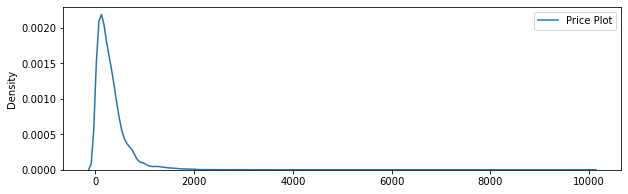

In [201]:
plt.figure(figsize=(10,3))
sns.distplot(X_train['price'].values, hist=False, label="Price Plot")
plt.legend()
plt.show()

In [202]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train['price'].values.reshape(-1, 1))

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.


X_train_price_nom = scaler.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_nom = scaler.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_nom = scaler.transform(X_test['price'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_price_nom.shape, y_train.shape)

print(X_test_price_nom.shape, y_test.shape)

After vectorizations
(32000, 1) (32000,)
(10000, 1) (10000,)


In [203]:
print(len(feature_for_importance))
feature_for_importance.extend(np.round(X_train['price'],2))

5595


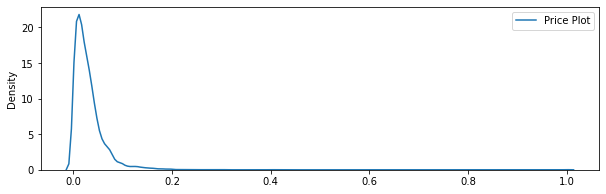

In [204]:
plt.figure(figsize=(10,3))
sns.distplot(X_train_price_nom, hist=False, label="Price Plot")
plt.legend()
plt.show()

<h3>1.4.6 encoding numerical features: teacher_number_of_previously_posted_projects</h3>

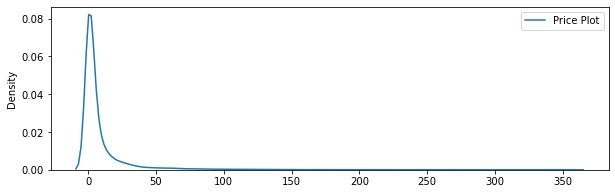

In [205]:
plt.figure(figsize=(10,3))
sns.distplot(X_train['teacher_number_of_previously_posted_projects'].values, hist=False, label="Price Plot")
plt.legend()
plt.show()

In [206]:
print(len(feature_for_importance))
feature_for_importance.extend(np.round(X_train['teacher_number_of_previously_posted_projects'],2))
print(len(feature_for_importance))
final_feature_names=feature_for_importance

37595
69595


In [207]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_previously_posted_norm = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_previously_posted_norm = scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previously_posted_norm = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_previously_posted_norm.shape, y_train.shape)

print(X_test_previously_posted_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(32000, 1) (32000,)
(10000, 1) (10000,)


In [208]:
X_train.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,preprocessed_titles
5076,ga,mrs,grades_3_5,2,literacy_language math_science,literacy mathematics,the students classroom inquisitive hard workin...,279.99,cheese memorable kindergarten year
47774,mn,mrs,grades_3_5,1,literacy_language math_science,literature_writing mathematics,my students come variety backgrounds our schoo...,368.32,frog fun
35767,pa,mrs,grades_prek_2,0,literacy_language math_science,literacy mathematics,there 30 second grade students classroom my st...,384.21,terrific tablets
19664,ny,ms,grades_9_12,3,history_civics,history_geography,in september i open classroom diverse group hi...,187.09,music movement baby falcons
6297,nc,mrs,grades_6_8,29,literacy_language music_arts,literacy visualarts,i teach rural extremely diverse middle school ...,1019.64,help us hear


### 1.4.7 Concatinating all the features

In [209]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow,X_train_preprocessed_titles_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_categories_ohe,X_train_subcategories_ohe,X_train_price_nom,X_train_previously_posted_norm)).tocsr()
X_cr=hstack((X_cv_essay_bow,X_cv_preprocessed_titles_bow, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe,X_cv_categories_ohe,X_cv_subcategories_ohe,X_cv_price_nom,X_cv_previously_posted_norm)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_preprocessed_titles_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_categories_ohe,X_test_subcategories_ohe,X_test_price_nom,X_test_previously_posted_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(32000, 5597) (32000,)
(10000, 5597) (10000,)


<h2>1.5 Applying KNN</h2>

In [210]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [11:01<00:00, 132.23s/it]


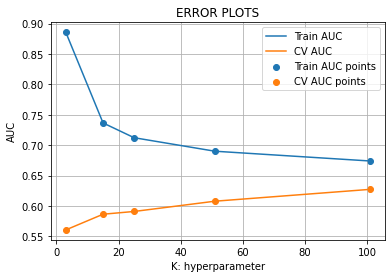

In [211]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [212]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 95

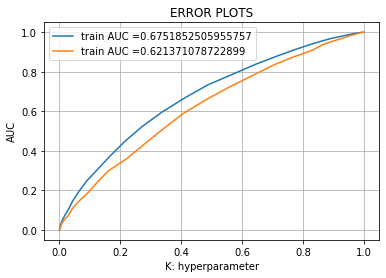

In [213]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### 1.5.3 Building Confusion Matrix

In [214]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [218]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
confusion_metric=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.3953455918321043 for threshold 0.8
Train confusion matrix


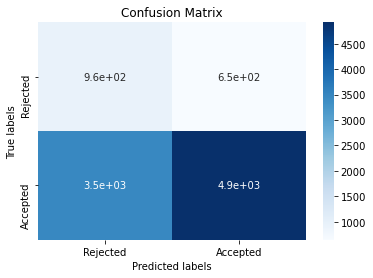

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot();
sns.heatmap(confusion_metric, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected','Accepted']); 
ax.yaxis.set_ticklabels(['Rejected','Accepted']);

## Performance of Model

In [323]:
def performance_model(y_test,y_pred):

    y_test_abs=[0 if x<0.5 else 1 for x in y_pred]
    correct_count=0
    num_correct=[i for i in range(y_test_pred.shape[0]) if y_test_abs[i]!=y_test[i]]
    incorrect_count+=len(num_correct)
    false_positive_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==0 and y_test_abs[i]==1)]
    false_positive=len(false_positive_ind)
    false_negative_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==1 and y_test_abs[i]==0)]
    false_negative=len(false_negative_ind)
    
    return incorrect_count,false_positive,false_negative
    

In [324]:
incorrect_count,false_positive,false_negative=performance_model(y_test,y_test_pred)
print("Print total number of misclassified points:",incorrect_count)
print("Total number of false positive points:",false_positive)
print("Total number of false negative points:",false_negative)

8386
1536
78


<h2>1.5 Appling MultinomialNB on different kind of featurization as mentioned in the instructions</h2>

<h3>1.5.1 Appling Multinomial Naive Bayes on features with [0.5,0.5] class priors</h3>

#### Training our model and finding the best hyperparameter with the help of cross validation data

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.96it/s]


Best alpha is : 0.001
[-5.0, -3.3010299956639813, -4.0, -2.3010299956639813, -3.0, -1.3010299956639813, -2.0, -1.0, -0.3010299956639812, 0.0, 0.6989700043360189, 1.0, 1.6989700043360187, 2.0]


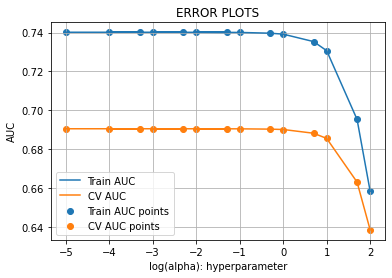

In [141]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes  import MultinomialNB
from sklearn.metrics import roc_auc_score
import math as mt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
t = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in tqdm(t):
    neigh = MultinomialNB(alpha=i,fit_prior = False,class_prior=[0.5, 0.5])
    neigh.fit(X_tr, y_train)
    log_alpha.append(mt.log10(i))

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
best_alpha=np.argmax(cv_auc)
new_alpha=t[best_alpha]
print('Best alpha is :',new_alpha)
print(log_alpha)
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

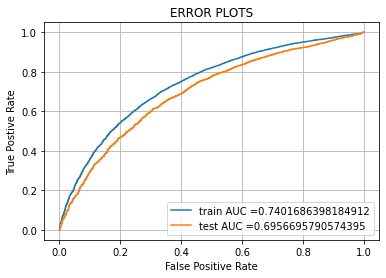

In [142]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=new_alpha,fit_prior=False,class_prior=[0.5, 0.5])
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [143]:
pos_class_prob_sorted = neigh.feature_log_prob_[1, :].argsort()[::-1][:20]

In [144]:
important_features=[final_feature_names[val] for val in pos_class_prob_sorted]
print('Ther 20 most important features are:',important_features)

Ther 20 most important features are: ['students', 'school', 'my', 'classroom', 'learning', 'the', 'not', 'they', 'learn', 'my students', 'help', 'many', 'nannan', 'work', 'reading', 'we', 'need', 'use', 'day', 'able']


<h2>1.6 Building Confusion Matrix<h2>

##### Seeting a threshold of 0.5 on predicted probabilities such that probabilities that are greater than 0.5 are put as 1 and probabilites that are lower than 0.5 are put as 0

In [145]:
y_test_pre=np.round(y_test_pred,2)

def y_test_threshold(var1):
    y_test_predict=[]
    for i in var1:
        if i>0.5:
            y_test_predict.append(1)
        else:
            y_test_predict.append(0)
    return y_test_predict

y_test_predict=np.array(y_test_threshold(y_test_pre))

In [146]:
confusion_metric=confusion_matrix(y_test, y_test_predict)

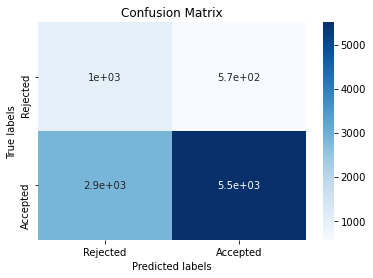

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot();
sns.heatmap(confusion_metric, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected','Accepted']); 
ax.yaxis.set_ticklabels(['Rejected','Accepted']);

## Performance of Model

In [323]:
def performance_model(y_test,y_pred):

    y_test_abs=[0 if x<0.5 else 1 for x in y_pred]
    correct_count=0
    num_correct=[i for i in range(y_test_pred.shape[0]) if y_test_abs[i]!=y_test[i]]
    incorrect_count+=len(num_correct)
    false_positive_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==0 and y_test_abs[i]==1)]
    false_positive=len(false_positive_ind)
    false_negative_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==1 and y_test_abs[i]==0)]
    false_negative=len(false_negative_ind)
    
    return incorrect_count,false_positive,false_negative
    

In [324]:
incorrect_count,false_positive,false_negative=performance_model(y_test,y_test_pred)
print("Print total number of misclassified points:",incorrect_count)
print("Total number of false positive points:",false_positive)
print("Total number of false negative points:",false_negative)

8386
1536
78


# 1.7 Logistic Regression

for alpha = 1e-06
for alpha = 1e-05
for alpha = 0.0001
for alpha = 0.001
for alpha = 0.01
for alpha = 0.1
for alpha = 1
for alpha = 10
for alpha = 100
Best alpha is : 0.001
[-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0]


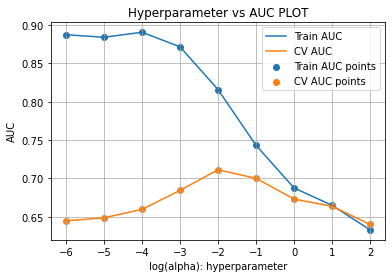

In [247]:
import math as mt


alpha=[10**x for x in range(-6,3)]

train_auc=[]
cv_auc=[]
log_alpha=[]
for i in alpha:
    print("for alpha =", i)
    clf=SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(X_tr,y_train)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(X_tr,y_train)
    log_alpha.append(mt.log10(i))
    
    y_train_pred=sig_clf.predict_proba(X_tr)[:,1]
    y_cv_pred=sig_clf.predict_proba(X_cr)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

    
best_alpha=np.argmax(cv_auc)
new_alpha=t[best_alpha]
print('Best alpha is :',new_alpha)
print(log_alpha)
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter vs AUC PLOT")
plt.grid()
plt.show()

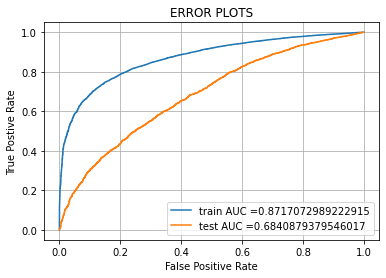

In [243]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_curve, auc


clf=SGDClassifier(class_weight='balanced',alpha=new_alpha,penalty='l2',loss='log',random_state=42)
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(X_tr,y_train)

    
y_train_pred=sig_clf.predict_proba(X_tr)[:,1]
y_test_pred=sig_clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [248]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [249]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
confusion_metric=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.635570132728304 for threshold 0.82
Train confusion matrix


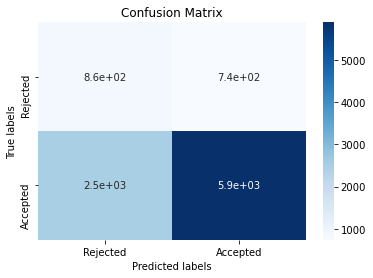

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot();
sns.heatmap(confusion_metric, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected','Accepted']); 
ax.yaxis.set_ticklabels(['Rejected','Accepted']);

## Performance of Model

In [323]:
def performance_model(y_test,y_pred):

    y_test_abs=[0 if x<0.5 else 1 for x in y_pred]
    correct_count=0
    num_correct=[i for i in range(y_test_pred.shape[0]) if y_test_abs[i]!=y_test[i]]
    incorrect_count+=len(num_correct)
    false_positive_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==0 and y_test_abs[i]==1)]
    false_positive=len(false_positive_ind)
    false_negative_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==1 and y_test_abs[i]==0)]
    false_negative=len(false_negative_ind)
    
    return incorrect_count,false_positive,false_negative
    

In [324]:
incorrect_count,false_positive,false_negative=performance_model(y_test,y_test_pred)
print("Print total number of misclassified points:",incorrect_count)
print("Total number of false positive points:",false_positive)
print("Total number of false negative points:",false_negative)

8386
1536
78


<h2>1.6 Random Forest Classifier</h2>

for n_estimators = 100 and max depth =  5
AUC score is: 0.6961325491844524
for n_estimators = 100 and max depth =  10
AUC score is: 0.6976384096784038
for n_estimators = 200 and max depth =  5
AUC score is: 0.697869151051831
for n_estimators = 200 and max depth =  10
AUC score is: 0.7012575404851773
for n_estimators = 500 and max depth =  5
AUC score is: 0.6984724944315925
for n_estimators = 500 and max depth =  10
AUC score is: 0.7017151891608716
for n_estimators = 1000 and max depth =  5
AUC score is: 0.7011817885337803
for n_estimators = 1000 and max depth =  10
AUC score is: 0.7046077053909015
for n_estimators = 2000 and max depth =  5
AUC score is: 0.7013788365545921
for n_estimators = 2000 and max depth =  10
AUC score is: 0.7051946668302537


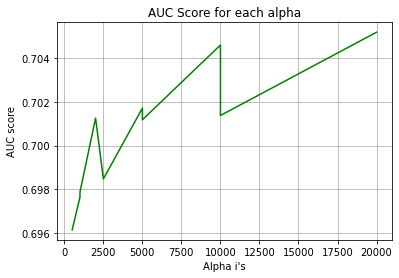

In [255]:
from sklearn.ensemble import RandomForestClassifier

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_auc=[]

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_tr, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_tr, y_train)
        log_alpha.append(mt.log10(i))
    
        y_train_pred=sig_clf.predict_proba(X_tr)[:,1]
        y_cv_pred=sig_clf.predict_proba(X_cr)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
        print('AUC score is:',roc_auc_score(y_cv,y_cv_pred))

#Since here we have combination of features. In order to obtain the right 
#combination we are first multiplying the two hyperparameters and after obtaining the right index, we will divide it by 2. Becuase for every hyperparameter their exist two combinations.

#Plotting cv_auc against features
fig,ax=plt.subplots()
features=np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features,cv_auc,c='g')


for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))

plt.grid()
plt.title("AUC Score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("AUC score")
plt.show()

### 1.6.1 Finiding the best Hyperparameter

In [259]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
combinations=[]
def hyp_combination(parm1,parm2):
    for i in parm1:
        for j in parm2:
            combinations.append((i,j))
    return combinations

best_alpha_index=np.argmax(cv_auc)
new_alpha=hyp_combination(max_depth,alpha)[best_alpha]
print(new_alpha)

### 1.6.2 Training our model on best hyperparameter

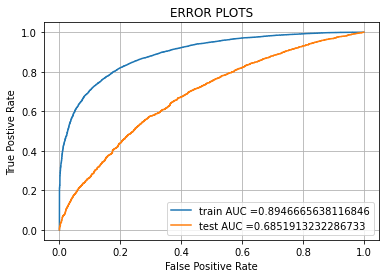

In [265]:
clf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(X_tr, y_train)

sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(X_tr,y_train)

y_train_pred=sig_clf.predict_proba(X_tr)[:,1]
y_test_pred=sig_clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [262]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [266]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
confusion_metric=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.658336177878616 for threshold 0.813
Train confusion matrix


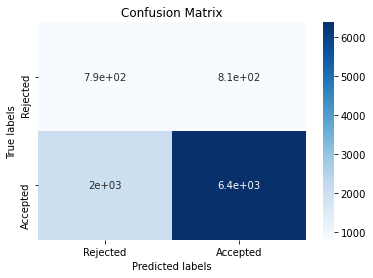

In [267]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot();
sns.heatmap(confusion_metric, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected','Accepted']); 
ax.yaxis.set_ticklabels(['Rejected','Accepted']);

## Performance of Model

In [323]:
def performance_model(y_test,y_pred):

    y_test_abs=[0 if x<0.5 else 1 for x in y_pred]
    correct_count=0
    num_correct=[i for i in range(y_test_pred.shape[0]) if y_test_abs[i]!=y_test[i]]
    incorrect_count+=len(num_correct)
    false_positive_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==0 and y_test_abs[i]==1)]
    false_positive=len(false_positive_ind)
    false_negative_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==1 and y_test_abs[i]==0)]
    false_negative=len(false_negative_ind)
    
    return incorrect_count,false_positive,false_negative
    

In [324]:
incorrect_count,false_positive,false_negative=performance_model(y_test,y_test_pred)
print("Print total number of misclassified points:",incorrect_count)
print("Total number of false positive points:",false_positive)
print("Total number of false negative points:",false_negative)

8386
1536
78


<h1>2 Using tfidf Vectorizer</h1>

<h3>2.1 Encoding essay variable<h3>

In [268]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(32000, 5000) (32000,)
  (0, 4876)	0.07114132436408305
  (0, 4839)	0.12784350172695935
  (0, 4837)	0.10090625616732693
  (0, 4553)	0.0428252049143037
  (0, 4540)	0.125168572311786
  (0, 4515)	0.07787939886089769
  (0, 4499)	0.05861809255982755
  (0, 4485)	0.12446249945708647
  (0, 4464)	0.08965735862071264
  (0, 4463)	0.09546370492172963
  (0, 4366)	0.3115269053034703
  (0, 4356)	0.06151287308892496
  (0, 4351)	0.1262738782630555
  (0, 4348)	0.051791573366794866
  (0, 4345)	0.08935739763922516
  (0, 4342)	0.04666586167314511
  (0, 4272)	0.11112529198151343
  (0, 4271)	0.08930781457128512
  (0, 4231)	0.11311163614782381
  (0, 4203)	0.1284634549859744
  (0, 4171)	0.062495214972743914
  (0, 4068)	0.09949832240110343
  (0, 4041)	0.10623323031635719
  (0, 4008)	0.10626996965632748
  (0, 4007)	0.12799001226564943
  :	:
  (7999, 1754)	0.040330908005511666
  (7999, 1637)	0.09689990472675185
  (7999, 1559)	0.08380499912021748
  (7999, 1503)	0.05536953279892849
  (7999, 1430

<h3>1.7.2 Encoding Titles</h3>

In [269]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=500)
vectorizer.fit(X_train['preprocessed_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_preprocessed_titles_tfidf = vectorizer.transform(X_train['preprocessed_titles'].values)
X_cv_preprocessed_titles_tfidf = vectorizer.transform(X_cv['preprocessed_titles'].values)
X_test_preprocessed_titles_tfidf = vectorizer.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(X_train_preprocessed_titles_tfidf.shape, y_train.shape)
print(X_cv_preprocessed_titles_tfidf.shape, y_cv.shape)
print(X_test_preprocessed_titles_tfidf.shape, y_test.shape)

After vectorizations
(32000, 500) (32000,)
(8000, 500) (8000,)
(10000, 500) (10000,)


<h3>1.7.3 Encoding School State</h3>

In [270]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_tfidf = vectorizer.transform(X_train['school_state'].values)
X_cv_state_tfidf = vectorizer.transform(X_cv['school_state'].values)
X_test_state_tfidf = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_tfidf.shape, y_train.shape)
print(X_test_state_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(32000, 51) (32000,)
(10000, 51) (10000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3>1.7.4 Encoding Teacher_Prefix</h3>

In [271]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_tfidf = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_tfidf = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_tfidf = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_tfidf.shape, y_train.shape)
print(X_test_teacher_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(32000, 5) (32000,)
(10000, 5) (10000,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


<h3>1.7.5 Encoding Project Grade Category</h3>

In [272]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_tfidf = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_tfidf = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_tfidf = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_tfidf.shape, y_train.shape)

print(X_test_grade_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names())


After vectorizations
(32000, 4) (32000,)
(10000, 4) (10000,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h3>1.7.6 Encoding Categories</h3>

In [273]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_categories_tfidf = vectorizer.transform(X_train['clean_categories'].values)
X_cv_categories_tfidf = vectorizer.transform(X_cv['clean_categories'].values)
X_test_categories_tfidf = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_categories_tfidf.shape, y_train.shape)

print(X_test_categories_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(32000, 7) (32000,)
(10000, 7) (10000,)
['appliedlearning', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds']


<h3>1.7.7 Encoding Clean Subcategories</h3>

In [274]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcategories_tfidf = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcategories_tfidf = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcategories_tfidf = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcategories_tfidf.shape, y_train.shape)

print(X_test_subcategories_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(32000, 28) (32000,)
(10000, 28) (10000,)
['appliedsciences', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts']


In [275]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,X_train_preprocessed_titles_tfidf, X_train_state_tfidf, X_train_teacher_tfidf, X_train_grade_tfidf,X_train_categories_tfidf,X_train_subcategories_tfidf,X_train_price_nom,X_train_previously_posted_norm)).tocsr()
X_cr=hstack((X_cv_essay_tfidf,X_cv_preprocessed_titles_tfidf, X_cv_state_tfidf, X_cv_teacher_tfidf, X_cv_grade_tfidf,X_cv_categories_tfidf,X_cv_subcategories_tfidf,X_cv_price_nom,X_cv_previously_posted_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf,X_test_preprocessed_titles_tfidf, X_test_state_tfidf, X_test_teacher_tfidf, X_test_grade_tfidf,X_test_categories_tfidf,X_test_subcategories_tfidf,X_test_price_nom,X_test_previously_posted_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(32000, 5597) (32000,)
(10000, 5597) (10000,)


<h2>1.5 Applying KNN</h2>

In [277]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [11:09<00:00, 133.97s/it]


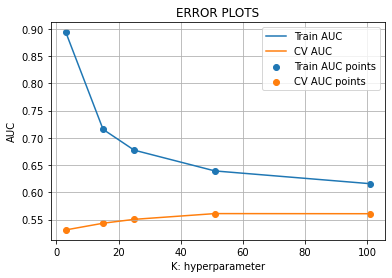

In [278]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [280]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
new_k_index = np.argmax(cv_auc)
best_k=K[new_k_index]
print(best_k)

51


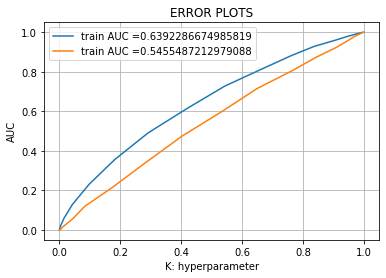

In [281]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### 1.5.3 Building Confusion Matrix

In [282]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [283]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
confusion_metric=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.35639132206466256 for threshold 0.843
Train confusion matrix


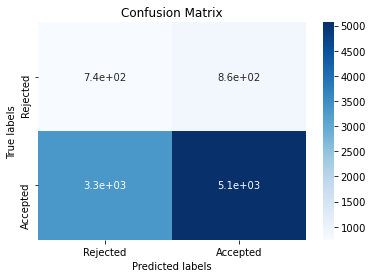

In [284]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot();
sns.heatmap(confusion_metric, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected','Accepted']); 
ax.yaxis.set_ticklabels(['Rejected','Accepted']);

## We train our model and plot AUC score for diff. values of hyperparameter 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.71it/s]


Best alpha when we use tfidf features is: 100
[-5.0, -3.3010299956639813, -4.0, -2.3010299956639813, -3.0, -1.3010299956639813, -2.0, -1.0, -0.3010299956639812, 0.0, 0.6989700043360189, 1.0, 1.6989700043360187, 2.0]


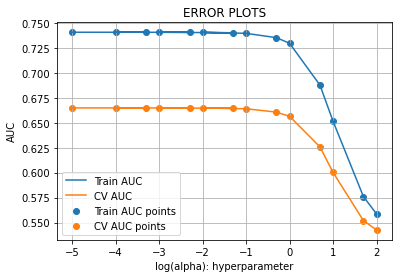

In [285]:
train_auc = []
cv_auc = []
t = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for i in tqdm(t):
    neigh = MultinomialNB(alpha=i,fit_prior=False,class_prior=[0.5, 0.5])
    neigh.fit(X_tr, y_train)
    log_alpha.append(mt.log10(i))

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
best_alpha=np.argmin(cv_auc)
new_alpha=t[best_alpha]
print('Best alpha when we use tfidf features is:',new_alpha)
print(log_alpha)
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Note: After obtaining the best hyperparameter we re train our model on it and further test it against test data

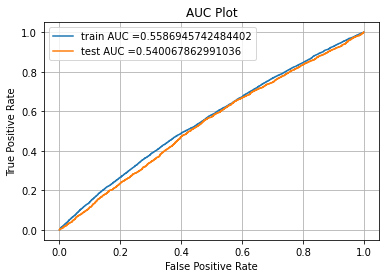

In [286]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=new_alpha,fit_prior=False,class_prior=[0.5, 0.5])
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Plot")
plt.grid()
plt.show()

## Bulding Confusion Matrix

##### Seeting a threshold of 0.5 on predicted probabilities such that probabilities that are greater than 0.5 are put as 1 and probabilites that are lower than 0.5 are put as 0

In [287]:
y_test_pre=np.round(y_test_pred,2)

def y_test_threshold(var1):
    y_test_predict=[]
    for i in var1:
        if i>0.5:
            y_test_predict.append(1)
        else:
            y_test_predict.append(0)
    return y_test_predict

y_test_predict=y_test_threshold(y_test_pre)

In [288]:
confusion_metric=confusion_matrix(y_test, y_test_predict)

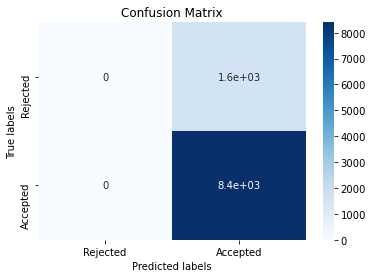

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot();
sns.heatmap(confusion_metric, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected','Accepted']); 
ax.yaxis.set_ticklabels(['Rejected','Accepted']);

## Performance of Model

In [323]:
def performance_model(y_test,y_pred):

    y_test_abs=[0 if x<0.5 else 1 for x in y_pred]
    correct_count=0
    num_correct=[i for i in range(y_test_pred.shape[0]) if y_test_abs[i]!=y_test[i]]
    incorrect_count+=len(num_correct)
    false_positive_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==0 and y_test_abs[i]==1)]
    false_positive=len(false_positive_ind)
    false_negative_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==1 and y_test_abs[i]==0)]
    false_negative=len(false_negative_ind)
    
    return incorrect_count,false_positive,false_negative
    

In [324]:
incorrect_count,false_positive,false_negative=performance_model(y_test,y_test_pred)
print("Print total number of misclassified points:",incorrect_count)
print("Total number of false positive points:",false_positive)
print("Total number of false negative points:",false_negative)

8386
1536
78


# 1.7 Logistic Regression with tfidf features

for alpha = 1e-06
for alpha = 1e-05
for alpha = 0.0001
for alpha = 0.001
for alpha = 0.01
for alpha = 0.1
for alpha = 1
for alpha = 10
for alpha = 100
Best alpha is : 0.0001
[-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0]


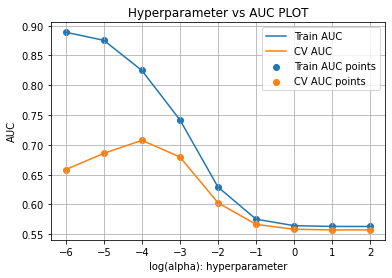

In [290]:
import math as mt


alpha=[10**x for x in range(-6,3)]

train_auc=[]
cv_auc=[]
log_alpha=[]
for i in alpha:
    print("for alpha =", i)
    clf=SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(X_tr,y_train)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(X_tr,y_train)
    log_alpha.append(mt.log10(i))
    
    y_train_pred=sig_clf.predict_proba(X_tr)[:,1]
    y_cv_pred=sig_clf.predict_proba(X_cr)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

    
best_alpha=np.argmax(cv_auc)
new_alpha=t[best_alpha]
print('Best alpha is :',new_alpha)
print(log_alpha)
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter vs AUC PLOT")
plt.grid()
plt.show()

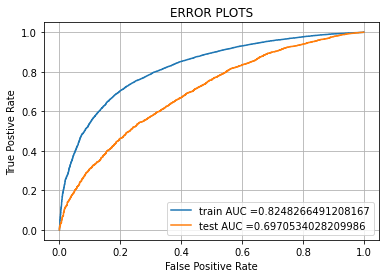

In [291]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_curve, auc


clf=SGDClassifier(class_weight='balanced',alpha=new_alpha,penalty='l2',loss='log',random_state=42)
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(X_tr,y_train)

    
y_train_pred=sig_clf.predict_proba(X_tr)[:,1]
y_test_pred=sig_clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [292]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [293]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
confusion_metric=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.5664438960862167 for threshold 0.825
Train confusion matrix


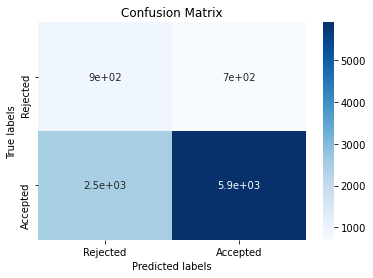

In [294]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot();
sns.heatmap(confusion_metric, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected','Accepted']); 
ax.yaxis.set_ticklabels(['Rejected','Accepted']);

## Performance of Model

In [323]:
def performance_model(y_test,y_pred):

    y_test_abs=[0 if x<0.5 else 1 for x in y_pred]
    correct_count=0
    num_correct=[i for i in range(y_test_pred.shape[0]) if y_test_abs[i]!=y_test[i]]
    incorrect_count+=len(num_correct)
    false_positive_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==0 and y_test_abs[i]==1)]
    false_positive=len(false_positive_ind)
    false_negative_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==1 and y_test_abs[i]==0)]
    false_negative=len(false_negative_ind)
    
    return incorrect_count,false_positive,false_negative
    

In [324]:
incorrect_count,false_positive,false_negative=performance_model(y_test,y_test_pred)
print("Print total number of misclassified points:",incorrect_count)
print("Total number of false positive points:",false_positive)
print("Total number of false negative points:",false_negative)

8386
1536
78


<h2>1.6 Random Forest Classifier with tfidf features</h2>

for n_estimators = 100 and max depth =  5
AUC score is: 0.6981000086092325
for n_estimators = 100 and max depth =  10
AUC score is: 0.7002638189509772
for n_estimators = 200 and max depth =  5
AUC score is: 0.6984175394116374
for n_estimators = 200 and max depth =  10
AUC score is: 0.7019577812997013
for n_estimators = 500 and max depth =  5
AUC score is: 0.6987128790749061
for n_estimators = 500 and max depth =  10
AUC score is: 0.7055277662852463
for n_estimators = 1000 and max depth =  5
AUC score is: 0.7008332366101746
for n_estimators = 1000 and max depth =  10
AUC score is: 0.7062305631472101
for n_estimators = 2000 and max depth =  5
AUC score is: 0.7017623598545331
for n_estimators = 2000 and max depth =  10
AUC score is: 0.706400075566057


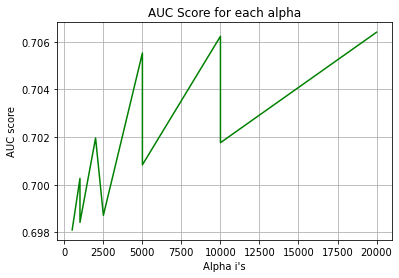

In [295]:
from sklearn.ensemble import RandomForestClassifier

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_auc=[]

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_tr, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_tr, y_train)
        log_alpha.append(mt.log10(i))
    
        y_train_pred=sig_clf.predict_proba(X_tr)[:,1]
        y_cv_pred=sig_clf.predict_proba(X_cr)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
        print('AUC score is:',roc_auc_score(y_cv,y_cv_pred))

#Since here we have combination of features. In order to obtain the right 
#combination we are first multiplying the two hyperparameters and after obtaining the right index, we will divide it by 2. Becuase for every hyperparameter their exist two combinations.

#Plotting cv_auc against features
fig,ax=plt.subplots()
features=np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features,cv_auc,c='g')


for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))

plt.grid()
plt.title("AUC Score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("AUC score")
plt.show()

### 1.6.1 Finiding the best Hyperparameter

In [296]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
combinations=[]
def hyp_combination(parm1,parm2):
    for i in parm1:
        for j in parm2:
            combinations.append((i,j))
    return combinations

best_alpha_index=np.argmax(cv_auc)
new_alpha=hyp_combination(max_depth,alpha)[best_alpha]
print(new_alpha)

(5, 500)


### 1.6.2 Training our model on best hyperparameter

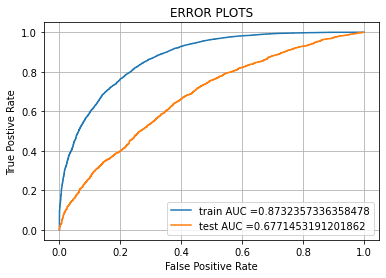

In [297]:
clf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(X_tr, y_train)

sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(X_tr,y_train)

y_train_pred=sig_clf.predict_proba(X_tr)[:,1]
y_test_pred=sig_clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [298]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [299]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
confusion_metric=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.6166740510493477 for threshold 0.823
Train confusion matrix


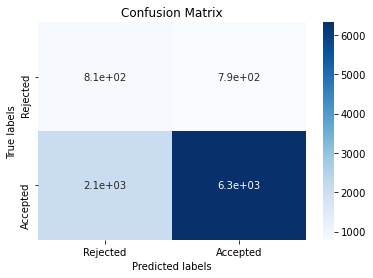

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot();
sns.heatmap(confusion_metric, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected','Accepted']); 
ax.yaxis.set_ticklabels(['Rejected','Accepted']);

## Performance of Model

In [323]:
def performance_model(y_test,y_pred):

    y_test_abs=[0 if x<0.5 else 1 for x in y_pred]
    correct_count=0
    num_correct=[i for i in range(y_test_pred.shape[0]) if y_test_abs[i]!=y_test[i]]
    incorrect_count+=len(num_correct)
    false_positive_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==0 and y_test_abs[i]==1)]
    false_positive=len(false_positive_ind)
    false_negative_ind=[i for i in range(y_test_pred.shape[0]) if (y_test[i]==1 and y_test_abs[i]==0)]
    false_negative=len(false_negative_ind)
    
    return incorrect_count,false_positive,false_negative
    

In [324]:
incorrect_count,false_positive,false_negative=performance_model(y_test,y_test_pred)
print("Print total number of misclassified points:",incorrect_count)
print("Total number of false positive points:",false_positive)
print("Total number of false negative points:",false_negative)

8386
1536
78


In [162]:
# https://www.geeksforgeeks.org/creating-tables-with-prettytable-library-python/
from prettytable import PrettyTable
myTable = PrettyTable(["Vectorizer", "Model", "Hyper Parameter", "AUC"])
  
# Add rows
myTable.add_row(["BOW", "Multinomail Naive Bayes", "14", "0.63 %"])
myTable.add_row(["Tfidf", "Multinomail Naive Bayes", "14", "0.54 %"])

print(myTable)

+------------+-------------------------+-----------------+--------+
| Vectorizer |          Model          | Hyper Parameter |  AUC   |
+------------+-------------------------+-----------------+--------+
|    BOW     | Multinomail Naive Bayes |        14       | 0.63 % |
|   Tfidf    | Multinomail Naive Bayes |        14       | 0.54 % |
+------------+-------------------------+-----------------+--------+


In [163]:
from scipy.sparse import vstack
x_train_grid=vstack((X_tr,X_cr)).tocsr()

In [164]:
x_train_grid.shape

(40000, 5601)

In [165]:
y_train_grid=np.hstack((y_train,y_cv))

In [166]:
type(y_train_grid)

numpy.ndarray

## Using Decision Tree with One Hot encoded features

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


decision_tree=DecisionTreeClassifier()
decision_tree.fit(x_train_grid,y_train_grid)

param_dict={"criterion":['gini'],"max_depth":range(1,10),"min_samples_split":range(1,10),"min_samples_leaf":range(1,5)}
grid=GridSearchCV(decision_tree,param_grid=param_dict,cv=StratifiedKFold(),verbose=1,n_jobs=-1)

In [98]:
grid.fit(x_train_grid,y_train_grid)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 22.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [99]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [100]:
grid.best_score_

0.83985

In [101]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=1)

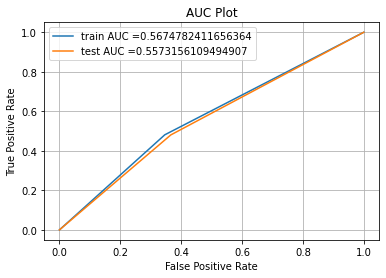

In [103]:
y_train_pred=grid.predict_proba(x_train_grid)[:,1]
y_test_pred=grid.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_grid, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Plot")
plt.grid()
plt.show()

In [167]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


decision_tree=DecisionTreeClassifier()
decision_tree.fit(x_train_grid,y_train_grid)

param_dict={"criterion":['gini'],"max_depth":range(1,10),"min_samples_split":range(1,10),"min_samples_leaf":range(1,5)}
grid=GridSearchCV(decision_tree,param_grid=param_dict,cv=StratifiedKFold(),verbose=1,n_jobs=-1)

In [168]:
grid.fit(x_train_grid,y_train_grid)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 40.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [169]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [170]:
grid.best_score_

0.83985

In [171]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=1)

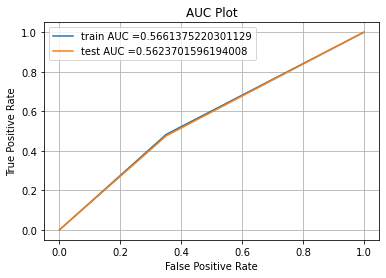

In [172]:
y_train_pred=grid.predict_proba(x_train_grid)[:,1]
y_test_pred=grid.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_grid, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Plot")
plt.grid()
plt.show()